# Visualise a generators bidding behavour

In order to get data for a specific unit we need to know it's DUID, which acts as its name inside AEMO's Market Managment 
System database (MMS). In this example we will look at Daydream solar farm.

The mapping of station names to DUIDs is published by AEMO in the NEM Registration and Exemption List MS Excel file. 
Note that when this file is updated by AEMO they remove retired generators. The NEMOSIS table that contains the mapping
from this file is called 'Generators and Scheduled Loads' its NEMOSIS wiki entry can be 
found [here](https://github.com/UNSW-CEEM/NEMOSIS/wiki/AEMO-Tables#generators-and-scheduled-loads-generators-and-scheduled-loads).

The bidding data, as used in dispatch, is published by AEMO in two MMS tables called BIDPEROFFER_D (volume bids) and 
BIDDAYOFFER_D, their NEMOSIS wiki entries can be found 
[here](https://github.com/UNSW-CEEM/NEMOSIS/wiki/AEMO-Tables#capacity-bids-bidperoffer_d) and 
[here](https://github.com/UNSW-CEEM/NEMOSIS/wiki/AEMO-Tables#price-bids-biddayoffer_d).

Before you get started:
* getting plotly (the graphing package I've used) working in a jupyter notebook takes a little bit of extra work but the process is well documented here: https://plotly.com/python/getting-started/

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from nemosis import static_table, dynamic_data_compiler
import plotly.express as px

In [3]:
# Specify where we will be caching the raw AEMO data.
raw_data_cache = 'C:/Users/N.Gorman/Desktop/cache'

In [4]:
# Download the latest Generators and Scheduled Loads table. The 
# update_static_file=True argument forces nemosis to download a new copy of 
# file from AEMO even if a copy already exists in the cache.
dispatch_units = static_table(table_name='Generators and Scheduled Loads', 
                              raw_data_location=raw_data_cache,
                              update_static_file=False)
dispatch_units.head()

Retrieving static table Generators and Scheduled Loads.


,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
0,AETV Pty Ltd,Bairnsdale Power Station,VIC1,Generator,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,BDL01
1,AETV Pty Ltd,Bairnsdale Power Station,VIC1,Generator,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,BDL02
2,AETV Pty Ltd,Chepstowe Wind Farm,VIC1,Generator,Market,Non-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,CHPSTWF1
3,AGL Hydro Partnership,Agl Kemps Creek,NSW1,Generator,Market,Non-Scheduled,Renewable/ Biomass / Waste,Landfill Methane / Landfill Gas,Combustion,Compression Reciprocating Engine,Y,AGLSITA1
4,AGL Hydro Partnership,Banimboola Power Station,VIC1,Generator,Market,Non-Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,BAPS


In [5]:
# Use pandas filtering to find the DUID of Daydream solar farm
dispatch_units[dispatch_units['Station Name'].str.contains('Murray')]

,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
462,Snowy Hydro Limited,Murray Power Station,VIC1,Generator,Market,Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,MURRAY


In [54]:
# Get the volume bids for the energy market.
volume_bids = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/03/07 00:00:00',
                                   table_name='BIDPEROFFER_D',
                                   raw_data_location=raw_data_cache)
volume_bids = volume_bids[(volume_bids['DUID'] == 'MURRAY') & 
                          (volume_bids['BIDTYPE'] == 'ENERGY')]
volume_bids.head()

Compiling data for table BIDPEROFFER_D.
Returning BIDPEROFFER_D.


,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME
9295863,2021-02-28,MURRAY,ENERGY,2021-02-28 19:45:52,1493,0.0,0.0,0.0,0.0,0,0,125,155,155,310,0,750,0,1575,2021-03-01 00:05:00
9296986,2021-02-28,MURRAY,ENERGY,2021-02-28 19:45:52,1493,0.0,0.0,0.0,0.0,0,0,125,155,155,310,0,750,0,1575,2021-03-01 00:10:00
9298090,2021-02-28,MURRAY,ENERGY,2021-02-28 19:45:52,1493,0.0,0.0,0.0,0.0,0,0,125,155,155,310,0,750,0,1575,2021-03-01 00:15:00
9299305,2021-02-28,MURRAY,ENERGY,2021-02-28 19:45:52,1493,0.0,0.0,0.0,0.0,0,0,125,155,155,310,0,750,0,1575,2021-03-01 00:20:00
9300430,2021-02-28,MURRAY,ENERGY,2021-02-28 19:45:52,1493,0.0,0.0,0.0,0.0,0,0,125,155,155,310,0,750,0,1575,2021-03-01 00:25:00


In [55]:
# Reshape the data such that each bid volume is on its own row.
volume_bids = pd.melt(volume_bids, id_vars=['INTERVAL_DATETIME'], 
                      value_vars=['BANDAVAIL1', 'BANDAVAIL2', 'BANDAVAIL3', 'BANDAVAIL4', 
                                  'BANDAVAIL5', 'BANDAVAIL6', 'BANDAVAIL7', 'BANDAVAIL8', 
                                  'BANDAVAIL9', 'BANDAVAIL10'],
                      var_name='BIDBAND', value_name='BIDVOLUME')
volume_bids.head()

,INTERVAL_DATETIME,BIDBAND,BIDVOLUME
0,2021-03-01 00:05:00,BANDAVAIL1,0
1,2021-03-01 00:10:00,BANDAVAIL1,0
2,2021-03-01 00:15:00,BANDAVAIL1,0
3,2021-03-01 00:20:00,BANDAVAIL1,0
4,2021-03-01 00:25:00,BANDAVAIL1,0


In [56]:
# Get the price bids.
price_bids = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/03/07 00:00:00',
                                   table_name='BIDDAYOFFER_D',
                                   raw_data_location=raw_data_cache)
price_bids = price_bids[price_bids['DUID'] == 'MURRAY']
price_bids.head()

Compiling data for table BIDDAYOFFER_D.
Returning BIDDAYOFFER_D.


,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4
3982,2021-02-28,MURRAY,LOWER6SEC,2021-02-14 20:10:42,1,0.00,4.50,6.00,15.00,30.00,100.00,250.00,2500.00,4800.00,14000.0,0.0,0.0,0.0,0.0,0.0
3983,2021-02-28,MURRAY,RAISE6SEC,2021-02-14 20:10:42,1,0.00,4.50,6.00,15.00,30.00,100.00,250.00,2500.00,4800.00,14000.0,0.0,0.0,0.0,0.0,0.0
3984,2021-02-28,MURRAY,RAISEREG,2021-02-14 20:10:42,1,0.01,10.98,13.99,19.99,33.99,99.99,269.98,450.99,1259.80,14698.0,0.0,0.0,0.0,0.0,0.0
11981,2021-02-28,MURRAY,ENERGY,2021-02-27 13:40:30,29,-967.40,0.00,8.89,19.35,29.02,53.21,145.11,289.74,435.15,14511.0,0.0,0.0,0.0,0.0,0.0
16187,2021-02-28,MURRAY,LOWERREG,2021-02-14 20:10:42,1,0.72,3.99,5.99,8.99,13.99,18.39,23.72,45.72,99.99,14698.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Reshape the data such that each bid volume is on its own row.
price_bids = pd.melt(price_bids, id_vars=['SETTLEMENTDATE'], 
                     value_vars=['PRICEBAND1', 'PRICEBAND2', 'PRICEBAND3', 'PRICEBAND4', 
                                 'PRICEBAND5', 'PRICEBAND6', 'PRICEBAND7', 'PRICEBAND8', 
                                 'PRICEBAND9', 'PRICEBAND10'],
                     var_name='BIDBAND', value_name='BIDPRICE')
price_bids.head()

,SETTLEMENTDATE,BIDBAND,BIDPRICE
0,2021-02-28,PRICEBAND1,0.00
1,2021-02-28,PRICEBAND1,0.00
2,2021-02-28,PRICEBAND1,0.01
3,2021-02-28,PRICEBAND1,-967.40
4,2021-02-28,PRICEBAND1,0.72


In [58]:
# Price bids are submitted daily and are applicable from the beggining of the market dat. 
# The first interval of the market day is 04:05:00, so we will add an applicable from column
# to make it easier to match volume and price bids.
price_bids['APPLICABLEFROM'] = price_bids['SETTLEMENTDATE'] + timedelta(hours=4, minutes=5)
price_bids.head()

,SETTLEMENTDATE,BIDBAND,BIDPRICE,APPLICABLEFROM
0,2021-02-28,PRICEBAND1,0.00,2021-02-28 04:05:00
1,2021-02-28,PRICEBAND1,0.00,2021-02-28 04:05:00
2,2021-02-28,PRICEBAND1,0.01,2021-02-28 04:05:00
3,2021-02-28,PRICEBAND1,-967.40,2021-02-28 04:05:00
4,2021-02-28,PRICEBAND1,0.72,2021-02-28 04:05:00


In [59]:
# To make it easier to match volume and price bids we will also convert the BIDBAND values to numeric
price_bids['BIDBAND'] = pd.to_numeric(price_bids['BIDBAND'].str[9:])
price_bids.head()

,SETTLEMENTDATE,BIDBAND,BIDPRICE,APPLICABLEFROM
0,2021-02-28,1,0.00,2021-02-28 04:05:00
1,2021-02-28,1,0.00,2021-02-28 04:05:00
2,2021-02-28,1,0.01,2021-02-28 04:05:00
3,2021-02-28,1,-967.40,2021-02-28 04:05:00
4,2021-02-28,1,0.72,2021-02-28 04:05:00


In [60]:
volume_bids['BIDBAND'] = pd.to_numeric(volume_bids['BIDBAND'].str[9:])
volume_bids.head()

,INTERVAL_DATETIME,BIDBAND,BIDVOLUME
0,2021-03-01 00:05:00,1,0


In [61]:
# Now we match each volume bid with the most recent price bid.
bids = pd.merge_asof(volume_bids.sort_values('INTERVAL_DATETIME'), 
                     price_bids.sort_values('APPLICABLEFROM'), 
                     left_on='INTERVAL_DATETIME', right_on='APPLICABLEFROM',
                     by='BIDBAND')
bids.head()

,INTERVAL_DATETIME,BIDBAND,BIDVOLUME,SETTLEMENTDATE,BIDPRICE,APPLICABLEFROM
0,2021-03-01 00:05:00,1,0,2021-02-28,0.0,2021-02-28 04:05:00
1,2021-03-01 00:05:00,2,0,2021-02-28,4.5,2021-02-28 04:05:00
2,2021-03-01 00:05:00,7,0,2021-02-28,250.0,2021-02-28 04:05:00
3,2021-03-01 00:05:00,6,310,2021-02-28,100.0,2021-02-28 04:05:00
4,2021-03-01 00:05:00,4,155,2021-02-28,15.0,2021-02-28 04:05:00


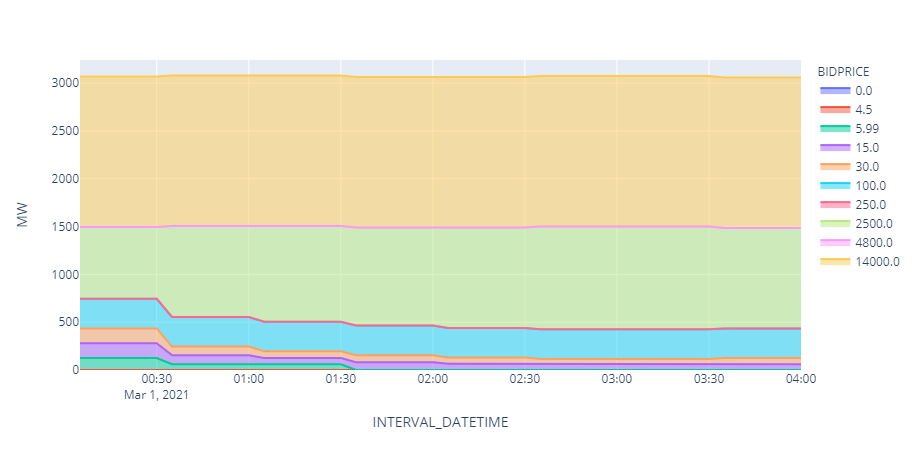

In [84]:
# Plot the results.
fig = px.area(bids.sort_values('BIDBAND'), x='INTERVAL_DATETIME', 
              y='BIDVOLUME', color='BIDPRICE')
fig.update_layout(yaxis_title="MW")
fig.show()